# [CSC 535/ 635] Data Mining Project- Movie Recommendation Systems

# By Group 1 (Dominic Bell, Sujung Choi, Seojin Park , Alex Hansen)

Below is the libraries you may need to install if you have not already; uncomment to download the library.\
The method of installing the library may vary slightly depending on the IDE environment

In [1]:
#!pip install scikit-surprise

#import sys
#!conda install --yes --prefix {sys.prefix} fuzzywuzzy

# reference: https://rasbt.github.io/mlxtend/installation/
#!conda install --yes --prefix {sys.prefix} mlxtend


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
random.seed(1)
np.random.seed(1)

#for KNN
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

# for SVD
from surprise import Reader, Dataset, SVD, accuracy, NormalPredictor
from surprise.model_selection import cross_validate, KFold, GridSearchCV
from collections import defaultdict

# for Apriori
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# load the data
ratings_data = pd.read_csv("ratings.csv")
movies_data = pd.read_csv("movies.csv")

# preprocessing, remove movies that are not rated by users from movies dataframe.

# select the columns we will use
ratings = ratings_data[['userId', 'movieId', 'rating']]

# number of unique movies
n_movies = len(ratings['movieId'].unique())
print("Number of movies:", n_movies) # number of movies is 9724

# Get the set of unique movieIds in the ratings dataframe
rated_movies = set(ratings['movieId'].unique())

# Filter the movies dataframe to keep only the movies that have been rated
movies = movies_data[movies_data['movieId'].isin(rated_movies)]

# Reset the index of the filtered dataframe
movies = movies.reset_index(drop=True)

# using groupby with movieId to see how many times each movie was rated by users
# (i.e., how many people rated a specific movie)
movie_counts = ratings_data.groupby('movieId').size()
movie_counts

Number of movies: 9724


movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Length: 9724, dtype: int64

In [2]:
# as we see above, there are multiple movies that are rated just one time (i.e., by one user), 
# meaning those rates does not really tell much thing as it does not represent the population.
# Therefore, here we limit movies that are rated at least 30 times.
filtered_movies = movie_counts[movie_counts>30]
filtered_movies_list = filtered_movies.index.tolist()
print("Numnber of movies that are rated by at least 30 people:", len(filtered_movies_list))

# assign the name movie_ratings to the filtered list of movies that were rated by more than 30 users
movie_ratings = ratings[ratings['movieId'].isin(filtered_movies_list)]

# merge the data
data_merged = pd.merge(movie_ratings, movies_data)
data_merged

Numnber of movies that are rated by at least 30 people: 860


,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
57353,495,1172,5.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
57354,587,1172,5.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
57355,597,1172,5.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
57356,603,1172,1.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [4]:
# to make comparison between original data and filtered data
# the original data
ratings.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [5]:
# the filtered data
movie_ratings.describe()

,userId,movieId,rating
count,57358.000000,57358.000000,57358.000000
mean,314.397277,11099.001761,3.661913
std,180.747840,23906.246467,0.994929
min,1.000000,1.000000,0.500000
25%,160.000000,653.000000,3.000000
50%,312.000000,2006.000000,4.000000
75%,474.000000,4993.000000,4.500000
max,610.000000,152081.000000,5.000000


<AxesSubplot:ylabel='rating'>

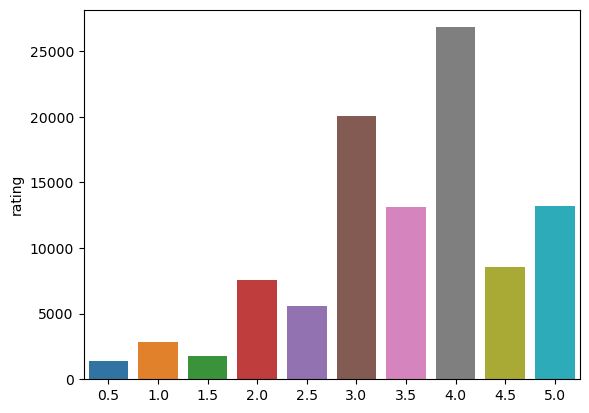

In [6]:
#plot a graph to see the distribution of the ratings of original data
sns.barplot(x = ratings.rating.value_counts().index, y = ratings_data.rating.value_counts())

<AxesSubplot:ylabel='rating'>

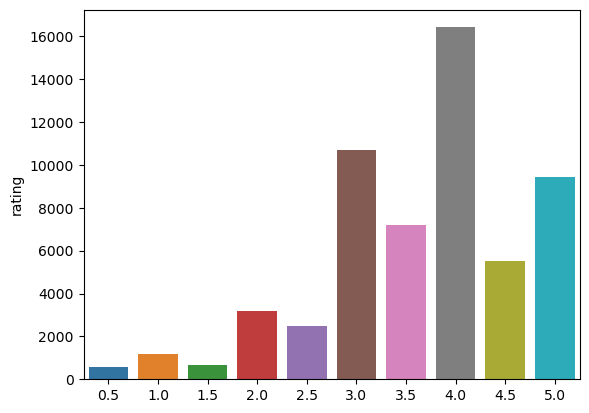

In [7]:
# check whether the distribution is the same as before; otherwise, the data may be skewed as we filtered
# here it turns out to be the same, so we can prove it still remains representative of the original data
sns.barplot(x=movie_ratings.rating.value_counts().index, y=movie_ratings.rating.value_counts())

In [3]:
# reshaping dataset to be used for KNN algorithm. Set userId as columns and movieId as an index. Replace NaN with zero.
movies_users = ratings.pivot(index='movieId', columns='userId', values = 'rating').fillna(0)
movies_users

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# KNN Algorithm

In [4]:
"""
This function takes user input for a favorite movie, finds the most similar movies using cosine similarity and nearest neighbors, 
and returns a list of recommended movies. 
"""
def KNN_recommendation():
    start = time.time()
    """
    creating a sparse matrix representation of the data in the movies_users data frame. 
    sparse matrix is needed since we should find consine similarity between vectors to recommend movies.
    The movies_users.values attribute returns the values in the movies_users data frame as a two-dimensional numpy array. 
    This numpy array is then passed as input to the csr_matrix() function, which returns a sparse matrix representation of the data in CSR format.
    """
    mat_movies = csr_matrix(movies_users.values) 
    # Creating a NearestNeighbor model using cosine similarity as the distance metric and the brute-force algorithm 
    # to compute the 5 nearest neighbors. 
    # instead of auto, use brute to obtain only results that meet requirements by exploring all possible cases. 
    model = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 1000)

    # fitting the model
    model.fit(mat_movies)

    # Take user input for movie name
    print("Example Movie: 'Toy Story (1995)'")
    print("Example Movie: 'Star Wars'")
    print("Example Movie: 'Love Jones (1997)'")
    print("Example Movie: 'Waydowntown (2000)'")
    print("Example Movie: 'Shiloh (1997)'")
    print("Example Movie: 'Shanghai Triad' \n")
    movie_name = input('Enter your favorite movie: ').strip()
    
    # [0] gives the name of the movie
    # [1] gives the percentage of matching
    # [2] gives index of movie that user entered. 
    
    # The process.extractOne() function from the fuzzywuzzy module is used to find the index of the movie that matches the user input. 
    idx = process.extractOne(movie_name, movies['title'])[2] 
    
    # prints out the name of the movie corresponding to the idx index
    print('Movie selected: ', movies['title'][idx])
    print("selected movie's genre: ", movies['genres'][idx])
    print('Searching for recommendation .......\n')
    
    # The model.kneighbors() function is used to find the nearest neighbors of the selected movie based on cosine similarity.
    # The mat_movies[idx] parameter specifies the row in the sparse matrix corresponding to the selected movie.
    # The n_neighbors parameter specifies the number of nearest neighbors to return. 
    # The resulting distance and indices arrays contain the cosine distances and indices of the recommended movies.
    distance, indices = model.kneighbors(mat_movies[idx], n_neighbors=6)  
    print('---------------------------------------------------------------')
    print('Here are 5 recommended movies: ')

    # loops through the indices array and prints out the titles of the recommended movies, 
    # excluding the movie that was selected by the user.
    for i in indices:
        for j in i:
            # We do not want to return the movie that was requested
            if j != (idx):
                print("-->", movies['title'][j])
                print("   Genres:", movies['genres'][j], "\n")
    # print out the cosine similarity between the selected movie and its nearest neighbors.
    # cosine similarity = 1 - cosine distance
    similarity_sum = 0
    for i in distance:
        for j_idx, j in enumerate(i):
            # We do not want to print out the consine similarity of the movie that was requested
            if j_idx != 0:
                print("similarity: ", (1-j) * 100, "%" )
                similarity_sum = similarity_sum + ((1-j) * 100)
    similarity_mean = similarity_sum / 5
    print('similarity mean: ', similarity_mean, "%" )
    end = time.time()
    print('---------------------------------------------------------------')
    print("\nTime taken for KNN Recommendation System " + str(end-start)+ " seconds")  

In [5]:
# it will ask user's input; you can simply type title with lower cases
# the system will still recognize without typing the year of release and capitalization of letters
KNN_recommendation()

Example Movie: 'Toy Story (1995)'
Example Movie: 'Star Wars'
Example Movie: 'Love Jones (1997)'
Example Movie: 'Waydowntown (2000)'
Example Movie: 'Shiloh (1997)'
Example Movie: 'Shanghai Triad' 

Enter your favorite movie: star wars
Movie selected:  Star Wars: Episode IV - A New Hope (1977)
selected movie's genre:  Action|Adventure|Sci-Fi
Searching for recommendation .......

---------------------------------------------------------------
Here are 5 recommended movies: 
--> Star Wars: Episode V - The Empire Strikes Back (1980)
   Genres: Action|Adventure|Sci-Fi 

--> Star Wars: Episode VI - Return of the Jedi (1983)
   Genres: Action|Adventure|Sci-Fi 

--> Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
   Genres: Action|Adventure 

--> Matrix, The (1999)
   Genres: Action|Sci-Fi|Thriller 

--> Indiana Jones and the Last Crusade (1989)
   Genres: Action|Adventure 

similarity:  83.2407355223372 %
similarity:  79.0638565561631 %
similarity:  70.8834116547

# SVD Algorithm

In [15]:
def SVD_recommendation(userId):
    """
    Returns top 10 movie recommendations for a given user based on their
    previous movie ratings using the SVD algorithm with GridSearchCV.

    Parameter:
    -----------
    userId : int
        ID of the user for which recommendations need to be generated.

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing top 10 movie recommendations that the user has not rated.
    """
    start = time.time()
    # This is a Reader class from Surprise library which expect a file containing data format to be [user, item, rating] order
    reader = Reader(rating_scale=(0,5))
    
    # This is a method load_from_df to read dataset from a pandas dataframe.
    # we are using preprocessed data
    data = Dataset.load_from_df(movie_ratings, reader)
    
    # uncomment below to use the original dataset (i.e., not preprocessed) instead (you should use either one of them, not both)
    #data = Dataset.load_from_df(ratings, reader)
    
    '''
    # 1) to use simple SVD without tuning the hyperparameters, uncomment this block of codes and comment the 2) tuning section out
    normal_svd = SVD(random_state = 1)
    train_data = data.build_full_trainset()
    normal_svd.fit(train_data)    
    test_data = train_data.build_anti_testset()
    prediction = normal_svd.test(test_data)
    '''
    #--------------------------------------------------------------------------------
    
    # 2) Tuning the SVD algorithm by using GridSearch
    # you can comment this block out to use SVD without tuning hyperparameters in the 1) section above
    param_grid = {"n_epochs": [10, 20, 30], "n_factors": [10, 50, 100], 'random_state': [1]}
    grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], n_jobs=-1, cv=KFold(5, random_state=1))
    grid_search.fit(data)

    # train the dataset with optimal best RMSE score after applying GridSearch
    # best_estimator is to apply the best "rmse" from the search
    svd = grid_search.best_estimator["rmse"]
    
    # optimal parameters (in this case, we only used n_epochs and n_factors) for the best RMSE score
    # you can uncomment the below commands to check the optimal parameters for the best RMSE score
    # it returns {'n_epochs': 30, 'n_factors': 10} when best RMSE score is 0.8376732332889455
    
    #print("best RMSE score:", grid_search.best_score["rmse"])
    #print("optimal parameters for the best RMSE score:", grid_search.best_params["rmse"])
    
    # build_full_trainset() method from surprise library is used to build a training set from a given dataset.
    # by default, the method assumes that all missing ratings are equal to zero. 
    train_data = data.build_full_trainset()
    svd.fit(train_data)
    
    # by using build_anti_testset() function, 
    # we can get a list of ratings containing all the possible rating combinations between the users and items 
    # that are not in the training set so that can be used as a test set
    test_data = train_data.build_anti_testset()
    prediction = svd.test(test_data)
    
   #----------------------------TUNING END-----------------------------------     

    # each prediction returns five values, which are userId, movieId, true rating, estimation, detail information
    #(e.g.user: 1 item: 318 r_ui = 3.66 est = 5.00 {'was_impossible': False})
    # therefore, we create dictionary to store the predicted ratings for each user by using list comprehension.
    top_rates = defaultdict(list)
    [top_rates[user].append((item, est)) for user, item, _, est, _ in prediction]

    # sort the predictions for each user and get the top 10 ratings.
    for user, user_ratings in top_rates.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_rates[user] = user_ratings[:10]
     
    # get the list of the user's previous ratings.
    # here it returns the highest rated 20 movies by the user from the existing data
    # which we can use for evalation/analysis if the new recommended movies are the sort of movies that user would like
    rated_movies_by_user = movie_ratings[movie_ratings.userId == userId].sort_values("rating").merge\
    (movies_data, how = 'left', on = 'movieId')
    
    user_top20 = rated_movies_by_user.tail(20)
    print(f'User id {userId} has previously rated {rated_movies_by_user.shape[0]} movies.')     
    print('---------------------------------------------------------------')
    print('\nTop 20 highly rated movies by this user from the existing record: \n', user_top20) 

    # to count the number of different genres of the top 20 movies user liked 
    # get_dummies() function create a new data frame with a column for each unique genre. 
    # And each row will have either 1 or 0 depending on whether the original genres column contained that genre or not.
    
    genre_counts = user_top20['genres'].str.get_dummies('|').sum().sort_values(ascending=False)
    print("\nThe number of each genre appeared in the user's top 20 rated movies: \n", genre_counts)
    
    # create a DF with predicted ratings. 
    predicted_rate = pd.DataFrame(
        [
         (id, pair[0],pair[1]) 
         for id, row in top_rates.items() 
         for pair in row
         if id == userId
        ],
        columns=["userId" ,"movieId","predicted_rating"],
    )
    
    # get the recommendations of top 10 movies that the user has not watched. 
    results = predicted_rate[predicted_rate["userId"] == (userId)].merge(movies_data, how = 'left', on = 'movieId')
    print('---------------------------------------------------------------')    
    print('\nTop 10 movies recommended for this user with predicted ratings: \n', results)

    # to count the number of different genres of the recommended movies
    genre_counts2 = results['genres'].str.get_dummies('|').sum().sort_values(ascending=False)
    print("\nThe number of recommened movie genres: \n", genre_counts2)

    end = time.time()
    print("\nTime taken for SVD Recommendation System " + str(end-start)+ " seconds")  

In [16]:
# you may change the input (i.e., userId) to different number to test the system
SVD_recommendation(391)

User id 391 has previously rated 244 movies.
---------------------------------------------------------------

Top 20 highly rated movies by this user from the existing record: 
      userId  movieId  rating  \
224     391      923     5.0   
225     391      924     5.0   
226     391      953     5.0   
227     391     1028     5.0   
228     391     2908     5.0   
229     391     1035     5.0   
230     391     2797     5.0   
231     391     2571     5.0   
232     391     1059     5.0   
233     391     1089     5.0   
234     391     2692     5.0   
235     391     2683     5.0   
236     391     1097     5.0   
237     391     1136     5.0   
238     391     1148     5.0   
239     391     1172     5.0   
240     391     1193     5.0   
241     391     1196     5.0   
242     391     1060     5.0   
243     391     1036     5.0   

                                                 title  \
224                                Citizen Kane (1941)   
225                       2001: A

In [17]:
# To evaluate the performance of the algorithms using cross validation
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(movie_ratings, reader)

# NormalPredictor is a basic algorithm from surprise library that gives random rating based on the distribution.
# it is used to see how much SVD algorithm can improve the accuracy of the prediction compared to this randomly recommending algorithm.
# refer: https://surprise.readthedocs.io/en/stable/basic_algorithms.html?highlight=NormalPredictor#surprise.prediction_algorithms.random_pred.NormalPredictor
base = NormalPredictor()
random_prediction = cross_validate(base, data, measures=['RMSE', 'MAE'], cv=KFold(5, random_state=1), verbose=True)
print('---------------------------------------------------------------')    
    
# the result below shows SVD decreases the Root Mean Square Error (RMSE) and Mean Absolute Error (MAE)
# meaning it performs better than the randomly recommended algorithm.
svd = SVD()    
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=KFold(5, random_state=1), verbose=True)


Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3430  1.3570  1.3580  1.3513  1.3424  1.3503  0.0066  
MAE (testset)     1.0631  1.0835  1.0794  1.0732  1.0645  1.0727  0.0080  
Fit time          0.08    0.10    0.09    0.09    0.08    0.09    0.01    
Test time         0.09    0.10    0.08    0.17    0.10    0.11    0.03    
---------------------------------------------------------------
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8386  0.8417  0.8454  0.8559  0.8413  0.8446  0.0061  
MAE (testset)     0.6413  0.6451  0.6450  0.6529  0.6453  0.6459  0.0038  
Fit time          0.67    0.65    0.59    0.69    0.83    0.69    0.08    
Test time         0.09    0.08    0.08    0.30    0.11    0.13    0.08    


Below is to plot pie charts for visualization of experiment results

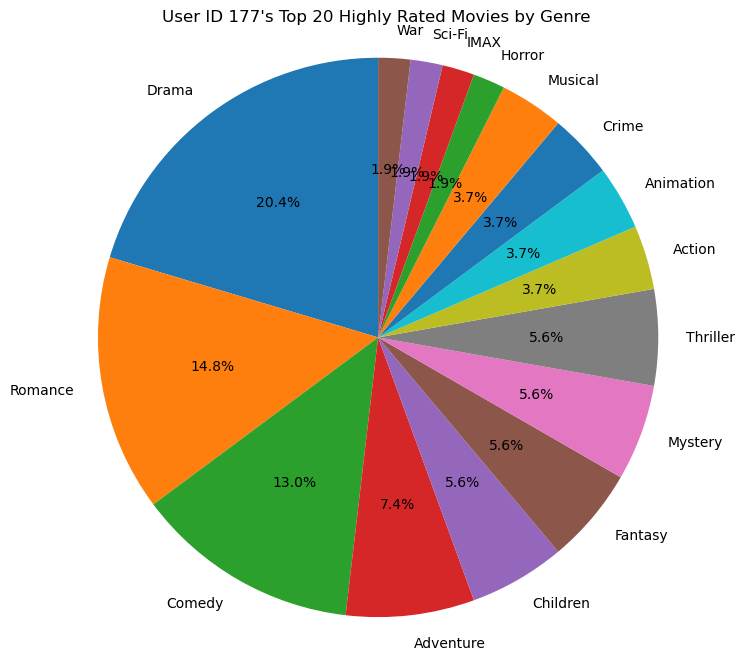

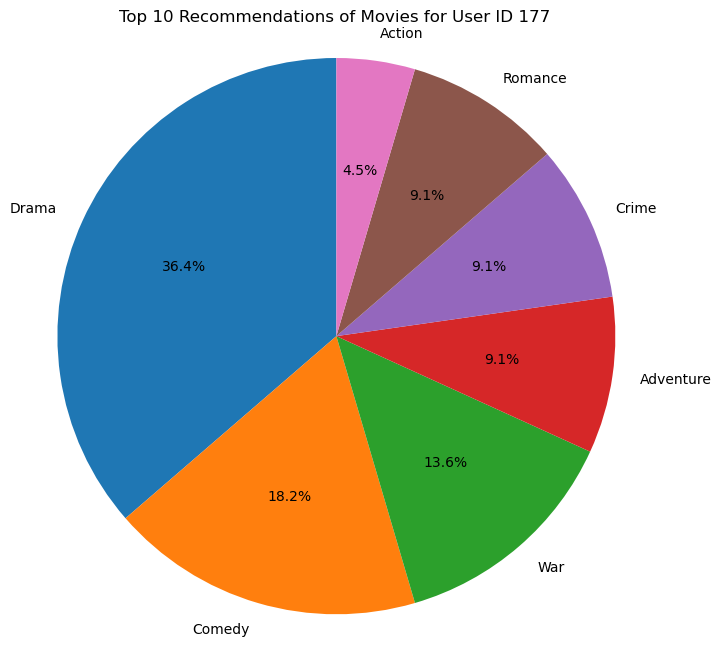

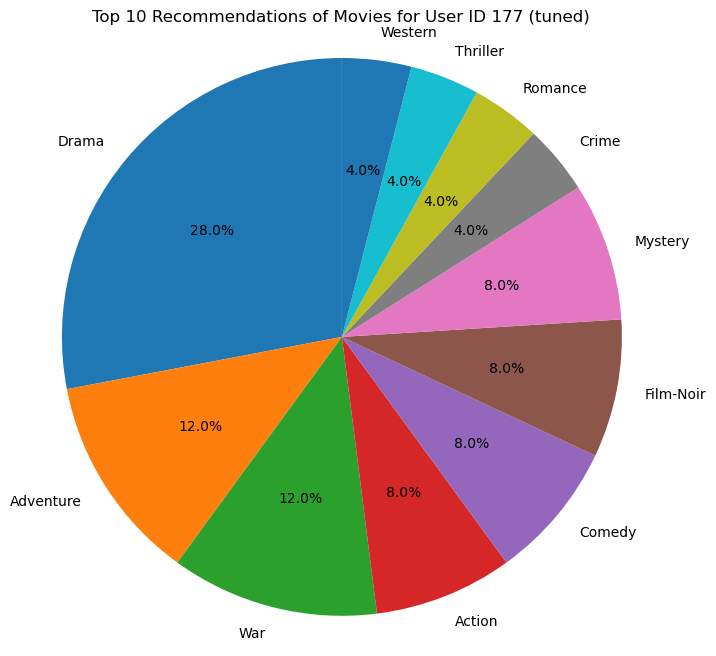

In [18]:
# Results for User ID 177

# genres of the top 20 rated movies by the user
genre_counts={
 'Drama':        11,
'Romance':       8,
'Comedy':        7,
'Adventure':     4,
'Children':      3,
'Fantasy':       3,
'Mystery':       3,
'Thriller':      3,
'Action':        2,
'Animation':     2,
'Crime':         2,
'Musical':       2,
'Horror':        1,
'IMAX':          1,
'Sci-Fi':        1,
'War':           1}

# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts.values(), labels=genre_counts.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("User ID 177's Top 20 Highly Rated Movies by Genre")
plt.show()

fig.savefig('user177_rated.jpg', dpi=300)

# recommended movies genres before tuning
genre_counts3 = {
 'Drama':        8,
'Comedy':       4,
'War':          3,
'Adventure':    2,
'Crime':        2,
'Romance':      2,
'Action':       1}
# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts3.values(), labels=genre_counts3.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("Top 10 Recommendations of Movies for User ID 177")
plt.show()
fig.savefig('user177_predict.jpg', dpi=300)

# recommended movies genres after tuning
genre_counts2 = {
'Drama':        7,
'Adventure':    3,
'War':          3,
'Action':       2,
'Comedy':       2,
'Film-Noir':    2,
'Mystery':      2,
'Crime':        1,
'Romance':      1,
'Thriller':     1,
'Western':      1}
# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts2.values(), labels=genre_counts2.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("Top 10 Recommendations of Movies for User ID 177 (tuned)")
plt.show()
fig.savefig('user177_predict_tuned.jpg', dpi=300)


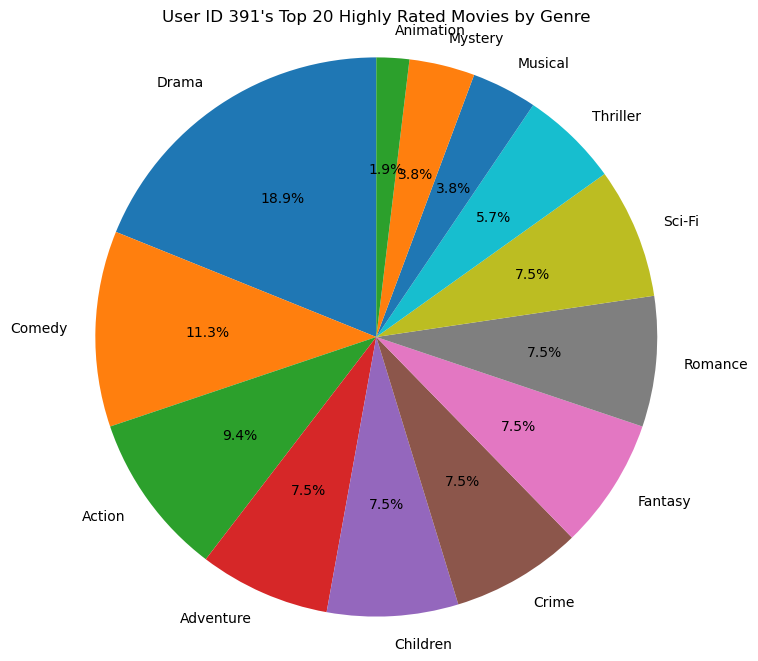

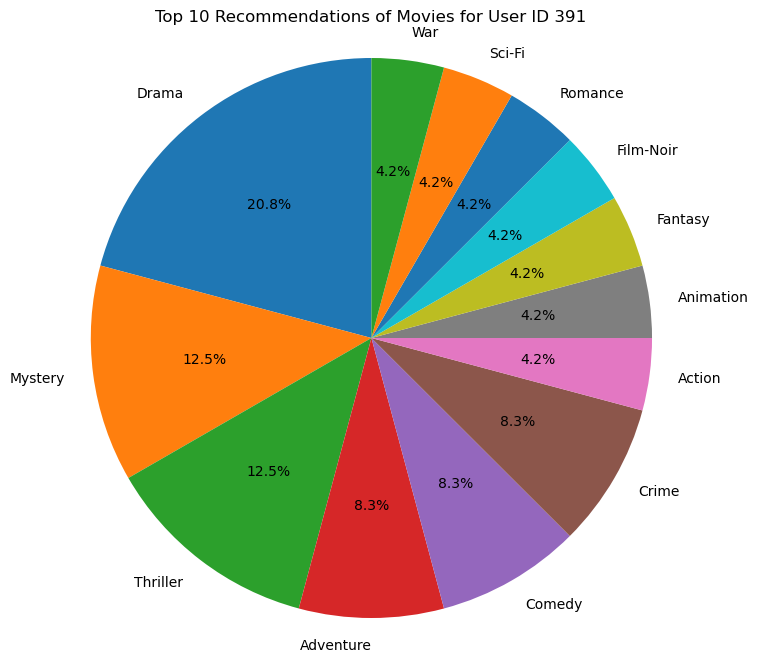

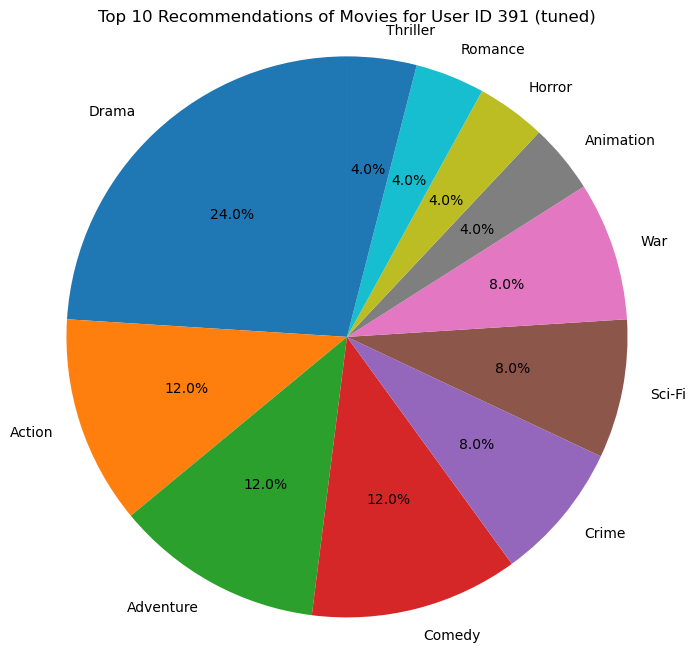

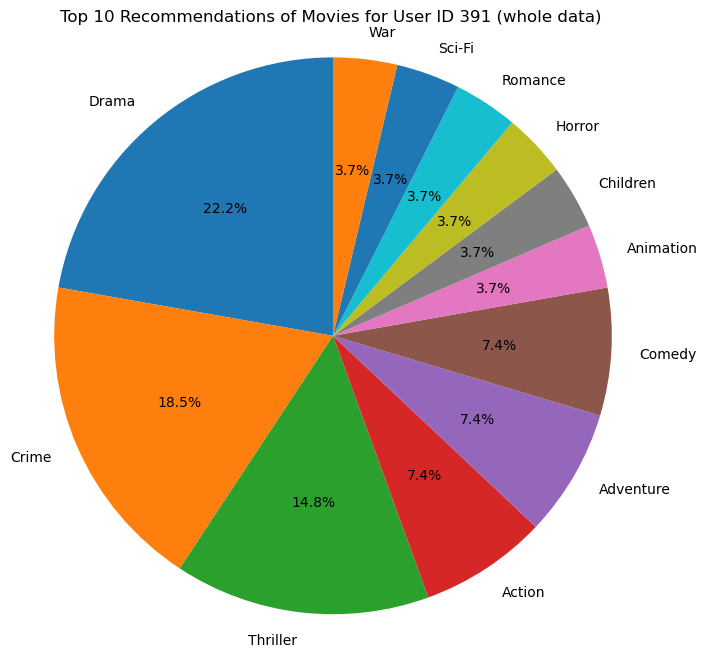

In [19]:
# Results for User ID 391

# genres of the top 20 rated movies by the user
genre_counts={
'Drama':  10,
'Comedy':        6,
'Action':        5,
'Adventure':     4,
'Children':      4,
'Crime':         4,
'Fantasy':       4,
'Romance':       4,
'Sci-Fi':        4,
'Thriller':      3,
'Musical':       2,
'Mystery':       2,
'Animation':     1}

# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts.values(), labels=genre_counts.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("User ID 391's Top 20 Highly Rated Movies by Genre")
plt.show()

fig.savefig('user391_rated.jpg', dpi=300)

# recommended movies genres before tuning
genre_counts3 = {
'Drama':        5,
'Mystery':      3,
'Thriller':     3,
'Adventure':    2,
'Comedy':       2,
'Crime':        2,
'Action':       1,
'Animation':    1,
'Fantasy':      1,
'Film-Noir':    1,
'Romance':      1,
'Sci-Fi':       1,
'War':          1}
# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts3.values(), labels=genre_counts3.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("Top 10 Recommendations of Movies for User ID 391")
plt.show()
fig.savefig('user391_predict.jpg', dpi=300)

# recommended movies genres after tuning
genre_counts2 = {
 'Drama':        6,
'Action':       3,
'Adventure':    3,
'Comedy':       3,
'Crime':        2,
'Sci-Fi':       2,
'War':          2,
'Animation':    1,
'Horror':       1,
'Romance':      1,
'Thriller':     1}
# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts2.values(), labels=genre_counts2.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("Top 10 Recommendations of Movies for User ID 391 (tuned)")
plt.show()
fig.savefig('user391_predict_tuned.jpg', dpi=300)

# recommended movies genres with whole dataset
genre_counts4 = {
'Drama':        6,
'Crime':        5,
'Thriller':     4,
'Action':       2,
'Adventure':    2,
'Comedy':       2,
'Animation':    1,
'Children':     1,
'Horror':       1,
'Romance':      1,
'Sci-Fi':       1,
'War':          1}
# Pie chart plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(genre_counts4.values(), labels=genre_counts4.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')

# Plot title and display the chart
plt.title("Top 10 Recommendations of Movies for User ID 391 (whole data)")
plt.show()
fig.savefig('user391_predict_whole.jpg', dpi=300)


# Apriori Algorithm

In [20]:
#  -------------------------------------------------------
# | Apriori - Loading, setting up, and cleaning the data |
# -------------------------------------------------------

# Removing nulls
apriori_movies_cleaned = movies_data.dropna(how = 'any')
apriori_movies_cleaned = apriori_movies_cleaned[['movieId','title']]

# Joining the two sets
apriori_joined_set = pd.merge(ratings, apriori_movies_cleaned, left_on='movieId', right_on='movieId')
# ^ df now gives -- index | userid | movieid | title | genres

# Trying to run the pivot below found duplicates, so first we must remove all of those
apriori_joined_set = apriori_joined_set.drop_duplicates(['userId','title'])

# Now we can create our new frame
apriori_joined_userId_index = apriori_joined_set.pivot(index='userId', columns='title', values ='rating')

# Cleaning data -- convert NaN to 0
apriori_joined_userId_index = apriori_joined_userId_index.fillna(0)

# Cleaning data -- converting reviews. if review is higher than 3 (3.5+), make it a 1, if lower, make it a 0
# The logic here is we only want to recommend movies that are not only associated, but also well received
apriori_joined_userId_index = apriori_joined_userId_index.replace([0.5,1,1.5,2,2.5,3], 0)
apriori_joined_userId_index = apriori_joined_userId_index.replace([3.5,4,4.5,5], 1)

# Renaming for easier use/readability...
apriori_dataset = apriori_joined_userId_index.astype('bool')


In [21]:
def apriori_train():
    start = time.time()
    #  -----------------------------
    # | Training the Apriori Model |
    # -----------------------------

    # using mlxtend to train the model
    itemset = apriori(apriori_dataset, min_support=0.07, use_colnames = True)
    lift = association_rules(itemset, metric="lift", min_threshold=1)

    # The way Apriori works, the higher the "lift" parameter, the better the match
    sorted_lift = lift.sort_values(by=['lift'], ascending=False)
    
    end = time.time()
    print('---------------------------------------------------------------')
    print("\nTime taken for Apriori Training " + str(end-start)+ " seconds")
    
    return sorted_lift
    
def apriori_recommend(sorted_lift):
    #  ----------------------------
    # | Testing the Apriori Model |
    # ----------------------------
    
    print("Example movies: ")
    print("-Toy Story")
    print("-Star Wars")
    print("-Shawshank Redemption, The")
    print("-Jumanji")
    print("-Heat")
    print("-Saving Private Ryan \n")

    movie_to_test = input("\n Enter a movie to test: \n").strip()
    
    # starting timer after input received
    start = time.time()
    
    # using fuzzywuzzy to extract the movie title even if not exactly correct
    movie_index = process.extractOne(movie_to_test, movies_data['title'])[2]
    movie_to_test = movies_data['title'][movie_index]
    
    print('Movie selected: ', movie_to_test)
    
    print("\n")
    
    # Calling the functions and storing the movies
    returndf = sorted_lift[sorted_lift['antecedents'].apply(lambda x: len(x) ==1 and next(iter(x)) == movie_to_test)]
    recommendations = returndf['consequents'].values
    
    # Getting the unique movies
    recommendation_list = []
    for movies in recommendations:
        for movie in movies:
            if movie not in recommendation_list:
                recommendation_list.append(movie)

    # Printing the top 5 movies
    # Can change 'limit' to receive more or less (if available)
    i = 0
    limit = 5
    # a condition if there are not recommendations found for the asked movie
    if len(recommendations) < limit:
        limit = len(recommendations)
        print(str(len(recommendations)) + " recommendations found that fit the support threshold.")
    while i < limit:
        print("--> ",recommendation_list[i]) 
        print(movies_data[movies_data['title']==recommendation_list[i]]['genres'].values, "\n")        
        i+=1

    end = time.time()
    print('---------------------------------------------------------------')
    print("\nTime taken for Apriori Recommendations " + str(end-start)+ " seconds")    

In [22]:
# This function was used to help us evaluate which min_support would be better
# it prints the time taken to train the set and returns a df with consequent count for each movie
# used below in apriori_graph
def evaluate(sup):
    itemset = apriori(apriori_dataset, min_support=sup, use_colnames = True)
    lift = association_rules(itemset, metric="lift", min_threshold=1)
    
    test_matches = lift[['antecedents','consequents']]
    grouped = test_matches.groupby("antecedents")["consequents"].count().reset_index()
     
    return grouped

In [23]:
def apriori_review_example_graph():
    # Comparison to display an example of apriori results.
    # "Toy Story" returns the sixth sense as an overlap despite how wrong that may seem due to the genres (kids vs horror)
    # This graph shows the strong relation between the two movies due to user reviews
    # This review overlap is why the strange recomendation shows up
    # 
    #print(apriori_dataset[(apriori_dataset['Sixth Sense, The (1999)']==True)&(apriori_dataset['Toy Story (1995)']==True)].count())
    # finds 70
    #print(apriori_dataset[apriori_dataset['Sixth Sense, The (1999)']==True].count())
    # finds 140
    # 140 - 70 = 70 for only sixth sense
    #print(apriori_dataset[apriori_dataset['Toy Story (1995)']==True].count())
    # finds 165
    # 165 - 70 = 95 for only toy story

    tags = ["Both", "The Sixth Sense (but not Toy Story)", "Toy Story (but not Sixth Sense)"]
    values = [70, 70, 95]
    barexplode = [0.1, 0, 0]
    plt.pie(values, labels = tags, shadow = True, explode = barexplode)
    plt.title("Number of Positive Reviews by Users")

In [24]:
def apriori_support_graph():
    # Showing how many movies for each minimum_support are "viable"
    # viable is determined as how many movies have atleast 5 consequents.
    # Each consequent is a possible recommendation.
    # it is okay to have many recomendations for some since we can sort by lift for the best.
    # but having less than 5 means, we cannot reccommend a full set.
    min_support_values = [0.1, 0.09, 0.08, 0.07]
    viable_percentages = []

    # finding the movies with >=5 consequents, then counting the unique ones
    # getting the ratio of viable/total movies as a %
    for min_support in min_support_values:
        results = evaluate(min_support)
        viable_results = results[results["consequents"] >= 5]
        viable_count = viable_results["antecedents"].nunique()
        viable_percentage = round((viable_count / n_movies) * 100, 2)
        viable_percentages.append(viable_percentage)
        print(f"{min_support} min_support allows apriori to recommend at least 5 movies for {viable_percentage}% of movies")
        
    # Creating a graph to display the difference in viability for different min_support values
    tags = ["0.10", "0.9", "0.8", "0.7"]
    plt.bar(tags, viable_percentages)
    plt.xlabel("Minimum Support")
    plt.ylabel("% of movies with >=5 consequences")
    plt.title("Comparing efficiency for different minimum_support values")


In [25]:
# Showing the strong relation between The Sixth Sense and Toy Story
# This helps show why Toy Story recommends a horry movie despire being a kids movie
#apriori_review_example_graph()

In [26]:
# to plot a graph showing the difference in viability for different min_support values
#apriori_support_graph()

In [28]:
# training the model
sorted_lift = apriori_train()

---------------------------------------------------------------

Time taken for Apriori Training 11.953582048416138 seconds


In [32]:
#it will ask user's input; you can just type title with lower cases
#it will still recognize without typing the year of release and capitalization of letters
apriori_recommend(sorted_lift)

Example movies: 
-Toy Story
-Star Wars
-Shawshank Redemption, The
-Jumanji
-Heat
-Saving Private Ryan 


 Enter a movie to test: 
heat
Movie selected:  Heat (1995)


-->  Saving Private Ryan (1998)
['Action|Drama|War'] 

-->  Matrix, The (1999)
['Action|Sci-Fi|Thriller'] 

-->  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
['Mystery|Sci-Fi|Thriller'] 

-->  Fargo (1996)
['Comedy|Crime|Drama|Thriller'] 

-->  Godfather, The (1972)
['Crime|Drama'] 

---------------------------------------------------------------

Time taken for Apriori Recommendations 0.8908147811889648 seconds
